# Predição de ativos da bolsa de valores

# Importa as bibliotecas

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go

import datetime
from pmdarima.arima import auto_arima # biblioteca que importa o arima
import pmdarima.arima as pm # biblioteca que importa o arima
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pandas as pd

from pandas_datareader import data 
import yfinance as yfin
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [2]:
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, MaxPooling1D, Activation, AveragePooling1D, BatchNormalization, Flatten, Dropout, SpatialDropout1D, GRU, GlobalAveragePooling1D
from tensorflow.keras import Input

2024-04-29 20:25:14.237817: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 20:25:14.240866: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 20:25:14.288585: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 20:25:14.288622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 20:25:14.289596: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Análise e visualização de ativos

### Carrega Dados

In [3]:
yfin.pdr_override()

acoes=['B3SA3','PETR4','KLBN11']
peso_acoes=np.ones(len(acoes))*1/len(acoes)
# adc o .SA no nome de cada ação para carregar no banco de dados
for i in range(np.size(acoes)):
    acoes[i]=acoes[i]+".SA"

acoes.append('^BVSP') # inclui o índice ibovespa na ultima coluna

acoes_df = pd.DataFrame() 
for acao in acoes:
     acoes_df[acao] = data.DataReader(acao, start='2010-01-01')['Close']

# substitui o .SA do nome de cada ação para visualização dos dados
for i in range(np.size(acoes)):
    acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('.SA', '')})

#renomeia o índice IBOVESPA para IBOV   
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})
                           
#soma todos os valores nulos
acoes_df.isnull().sum()

#Verifica como está o shape do dataframe
acoes_df.shape
 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(3553, 4)

<Axes: ylabel='Date'>

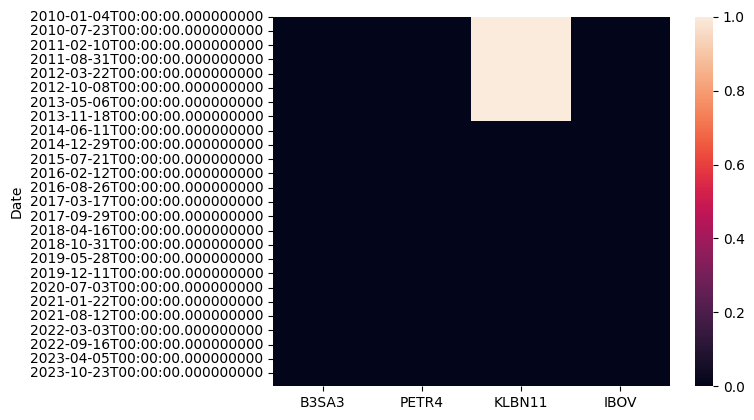

In [4]:
sns.heatmap(acoes_df.isnull())

In [5]:
#apaga registros nulos
acoes_df.dropna(inplace=True)
acoes_df.to_csv('acoes.csv')
acoes_df

B3SA3      PETR4     KLBN11           IBOV
Date                                                      
2014-01-23   3.250000  15.470000  11.744000   48321.000000
2014-01-24   3.233333  15.100000  11.744000   47787.000000
2014-01-27   3.300000  15.110000  11.744000   47701.000000
2014-01-28   3.280000  15.050000  12.586000   47841.000000
2014-01-29   3.170000  14.800000  12.350000   47557.000000
...               ...        ...        ...            ...
2024-04-23  11.090000  41.419998  23.870001  125148.000000
2024-04-24  10.940000  41.230000  23.580000  124741.000000
2024-04-25  10.830000  42.220001  23.250000  124646.000000
2024-04-26  11.220000  41.650002  23.090000  126526.000000
2024-04-29  11.140000  42.150002  23.139999  127351.789062

[2543 rows x 4 columns]

### Visualização dos dados 

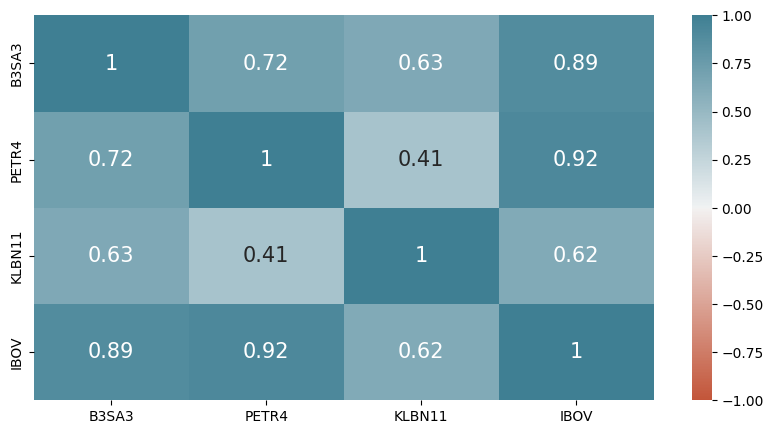

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))

columns=acoes_df.columns
corrmat = acoes_df[columns].corr()
mask= np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrmat,
            vmax=1, vmin=-1,
            annot=True, annot_kws={'fontsize':15},
            cmap=sns.diverging_palette(20,220,as_cmap=True))
plt.show()

In [7]:
# Normaliza os dados
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [8]:
acoes_df_normalized

B3SA3     PETR4    KLBN11      IBOV
Date                                              
2014-01-23  1.000000  1.000000  1.000000  1.000000
2014-01-24  0.994872  0.976083  1.000000  0.988949
2014-01-27  1.015385  0.976729  1.000000  0.987169
2014-01-28  1.009231  0.972851  1.071696  0.990066
2014-01-29  0.975385  0.956690  1.051601  0.984189
...              ...       ...       ...       ...
2024-04-23  3.412308  2.677440  2.032527  2.589930
2024-04-24  3.366154  2.665158  2.007834  2.581507
2024-04-25  3.332308  2.729153  1.979734  2.579541
2024-04-26  3.452308  2.692308  1.966110  2.618447
2024-04-29  3.427692  2.724628  1.970368  2.635537

[2543 rows x 4 columns]

In [9]:
#%% Carregando dados
acoes_df=pd.read_csv('acoes.csv')
acoes_df['Date']=pd.to_datetime(acoes_df['Date'])
acoes_df=acoes_df.set_index('Date')
for col in acoes_df.columns:
    acoes_df[col]=acoes_df[col].astype('float32')

In [10]:
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [11]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
for acoes in acoes_df.columns:
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['IBOV'], mode='lines', name='Preço do Ibovespa'))
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['B3SA3'], mode='lines', name='Preço do B3SA3'))
    fig.add_trace(go.Scatter(x=acoes_df_normalized.index, y=acoes_df_normalized[acoes], mode='lines', name=f'Preço do {acoes}'))

# Configura o layout do gráfico
fig.update_layout(
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)

# Exibe o gráfico
fig.show()

## Indicadores de tendência e Séries Temporais 

Os swing traders geralmente utilizam médias móveis exponenciais (EMAs) de diferentes períodos para identificar tendências e sinais de compra e venda. As EMAs mais utilizadas pelos swing traders incluem:

-EMA de 9 períodos: A EMA de 9 períodos é comumente usada para identificar sinais de curto prazo e capturar movimentos rápidos do mercado. Pode fornecer sinais mais sensíveis e frequentes.

-EMA de 20 períodos: A EMA de 20 períodos é amplamente utilizada e considerada uma média móvel de curto prazo. É usada para identificar a direção da tendência de curto prazo e possíveis pontos de reversão.

-EMA de 50 períodos: A EMA de 50 períodos é frequentemente usada para identificar a direção da tendência de médio prazo. É uma média móvel amplamente observada pelos swing traders.

-EMA de 100 períodos: A EMA de 100 períodos é usada para identificar a direção da tendência de médio a longo prazo. É útil para identificar pontos de entrada e saída em operações de swing trading mais prolongadas.

-EMA de 200 períodos: A EMA de 200 períodos é uma das médias móveis mais amplamente observadas e é usada para identificar a direção da tendência de longo prazo. É frequentemente usada como um indicador-chave para determinar a tendência geral do mercado.

In [12]:
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})


In [13]:
import pandas as pd
import pandas_datareader as pdr
import datetime
import plotly.graph_objects as go

# Define o código de ticker da ação
ticker = "^BVSP"
ticker = "B3SA3"


if ticker!="^BVSP":
    ticker=ticker+".SA"

# Obtém os dados históricos da ação
df = data.DataReader(ticker, start='2015-01-01')



[*********************100%%**********************]  1 of 1 completed


In [14]:
scaler = MinMaxScaler()
y=scaler.fit_transform(df['Close'].values.reshape(-1,1))

# Function to compute Simple Moving Average (SMA)
def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# Function to compute Relative Strength Index (RSI)
def calculate_rsi(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to compute Moving Average Convergence Divergence (MACD)
def calculate_macd(data, short_window, long_window, signal_window):
    short_ema = data['Close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    return macd_line, signal_line

def calculate_bollinger_bands(data, window=20, num_std=2):
    sma = data['Close'].rolling(window=window).mean()
    std = data['Close'].rolling(window=window).std()
    upper_band = sma + num_std * std
    lower_band = sma - num_std * std
    return upper_band, lower_band

df['upper_band_bollinger'],df['lower_band_bollinger']=calculate_bollinger_bands(df)
# Calcula as EMAs de 9 e 20 períodos
df['EMA9'] = df['Close'].ewm(span=9).mean()
df['EMA20'] = df['Close'].ewm(span=20).mean()
df['EMA50'] = df['Close'].ewm(span=50).mean()
df['EMA100'] = df['Close'].ewm(span=100).mean()
df['EMA200'] = df['Close'].ewm(span=200).mean()
df['MA111*2'] = df['Close'].rolling(window=111).mean() * 2
df['MA350*2'] = df['Close'].rolling(window=350).mean() * 2


# Calculate RSI (14-period)
df['RSI_14'] = calculate_rsi(df, window=14)

# Calculate MACD (12, 26, 9)
df['MACD'], df['Signal'] = calculate_macd(df, short_window=12, long_window=26, signal_window=9)


In [15]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['EMA9'], mode='lines', name='EMA9'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA20'], mode='lines', name='EMA20'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA50'], mode='lines', name='EMA50'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA100'], mode='lines', name='EMA100'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA200'], mode='lines', name='EMA200'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA111*2'], mode='lines', name='MA111*2'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA350*2'], mode='lines', name='MA350*2'))

if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [16]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['upper_band_bollinger'], mode='lines', name='upper band bollinger'))
fig.add_trace(go.Scatter(x=df.index, y=df['lower_band_bollinger'], mode='lines', name='lower band bollinger'))


if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [17]:

# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
df['Variation'] = ((df['Close'] - df['Close'].shift(+1)) / df['Close'])*100
#pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100


# Thresholds for variation classification
positive_threshold = 0.03
negative_threshold = -0.03

# Create a new column for classified variation
df['Classification'] = df['Variation'].apply(lambda x: 
                                            1 if x > positive_threshold else (
                                                -1 if x < negative_threshold else 0))

#df['week']=df.index.week
df['weekday']=df.index.weekday+1
df['day']=df.index.day
df['month']=df.index.month
df['quarter']=df.index.quarter

df=df.reset_index().fillna(0)
df


Date       Open       High        Low      Close  Adj Close  \
0    2015-01-02   3.270000   3.270000   3.150000   3.170000   2.269296   
1    2015-01-05   3.143333   3.153333   3.056666   3.083333   2.207255   
2    2015-01-06   3.066666   3.113333   3.033333   3.113333   2.228731   
3    2015-01-07   3.133333   3.283333   3.126666   3.236666   2.317021   
4    2015-01-08   3.296666   3.300000   3.190000   3.193333   2.286000   
...         ...        ...        ...        ...        ...        ...   
2313 2024-04-23  11.150000  11.240000  11.040000  11.090000  11.090000   
2314 2024-04-24  11.080000  11.100000  10.890000  10.940000  10.940000   
2315 2024-04-25  10.910000  10.940000  10.750000  10.830000  10.830000   
2316 2024-04-26  10.970000  11.270000  10.870000  11.220000  11.220000   
2317 2024-04-29  11.200000  11.310000  11.090000  11.140000  11.140000   

        Volume  upper_band_bollinger  lower_band_bollinger       EMA9  ...  \
0     21734100              0.000000              0.000000   3.170000  ...   
1     34790100              0.000000              0.000000   3.121852  ...   
2     49214700              0.000000              0.000000   3.118360  ...   
3     24006600              0.000000              0.000000   3.158437  ...   
4     22967700              0.000000              0.000000   3.168818  ...   
...        ...                   ...                   ...        ...  ...   
2313  44050500             12.457288             10.939712  11.368290  ...   
2314  45024900             12.474290             10.826710  11.282632  ...   
2315  32548600             12.472312             10.709688  11.192106  ...   
2316  60635700             12.427675             10.677325  11.197685  ...   
2317  43222800             12.408478             10.633522  11.186148  ...   

        MA350*2     RSI_14      MACD    Signal  Variation  Classification  \
0      0.000000   0.000000  0.000000  0.000000   0.000000               0   
1      0.000000   0.000000 -0.006914 -0.001383  -2.810824              -1   
2      0.000000   0.000000 -0.009858 -0.003078   0.963597               1   
3      0.000000   0.000000 -0.002215 -0.002905   3.810494               1   
4      0.000000   0.000000  0.000343 -0.002256  -1.356985              -1   
...         ...        ...       ...       ...        ...             ...   
2313  25.565886  36.681230 -0.317667 -0.266794  -1.623087              -1   
2314  25.559371  26.605497 -0.335580 -0.280552  -1.371120              -1   
2315  25.549543  23.999998 -0.354565 -0.295354  -1.015694              -1   
2316  25.540914  31.872515 -0.334288 -0.303141   3.475939               1   
2317  25.533657  23.175965 -0.320973 -0.306707  -0.718132              -1   

      weekday  day  month  quarter  
0           5    2      1        1  
1           1    5      1        1  
2           2    6      1        1  
3           3    7      1        1  
4           4    8      1        1  
...       ...  ...    ...      ...  
2313        2   23      4        2  
2314        3   24      4        2  
2315        4   25      4        2  
2316        5   26      4        2  
2317        1   29      4        2  

[2318 rows x 25 columns]

## Data preprocessing to stock forecast

### Pré-processamento dos dados para predição 

In [18]:
ticker

'B3SA3.SA'

In [19]:
# Pré-processamento dos dados
acoes_df.reset_index(inplace=True)
#ticker='IBOV'
if 'SA' in ticker:
    ticker=ticker[:-3]
    
acoes_df = acoes_df[['Date', ticker]]
acoes_df.columns = ['ds', 'y']

In [20]:
# scale the data - normalization
acoes_df_norm=acoes_df.copy()
scaler = MinMaxScaler()
acoes_df_norm['y'] = scaler.fit_transform(acoes_df['y'].values.reshape(-1,1))

In [21]:
features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200',
                     'RSI_14', 'MACD','upper_band_bollinger', 'lower_band_bollinger']
acoes_df = df[['Close']+features_indicators]  
acoes_df_normalized = acoes_df / acoes_df.max().values
acoes_df_normalized.describe()
acoes_df['ds']=df['Date']

/tmp/ipykernel_70578/925237688.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
[feature.split('_') for feature in features_indicators]

[['EMA9'],
 ['EMA20'],
 ['EMA50'],
 ['EMA100'],
 ['EMA200'],
 ['RSI', '14'],
 ['MACD'],
 ['upper', 'band', 'bollinger'],
 ['lower', 'band', 'bollinger']]

In [23]:
def comput_features(data_array, lookback = 1, features_indicators=[]):
    """_summary_

    Args:
        data_array (_type_): transformed dat in scaler 
        lookback (int, optional): _description_. Defaults to 1.
        features_indicators (list, optional): _description_. Defaults to [].

    Returns:
        _type_: _description_
    """
    #df_=pd.DataFrame(data=scaler.inverse_transform(data_array.reshape(-1,1)),columns=['Close'])
    df_=pd.DataFrame(data=data_array.reshape(-1,1),columns=['Close'])


    if  True in ['bollinger' in feature.split('_') for feature in features_indicators]:
        df_['upper_band_bollinger'],df_['lower_band_bollinger']=calculate_bollinger_bands(df_)
    # Calcula as EMAs de 9 e 20 períodos
    if 'EMA9' in features_indicators:
        df_['EMA9'] = df_['Close'].ewm(span=9).mean()
    if 'EMA20' in features_indicators:   
        df_['EMA20'] = df_['Close'].ewm(span=20).mean()
    if 'EMA50' in features_indicators: 
        df_['EMA50'] = df_['Close'].ewm(span=50).mean()
    if 'EMA100' in features_indicators: 
        df_['EMA100'] = df_['Close'].ewm(span=100).mean()
    if 'EMA200' in features_indicators: 
        df_['EMA200'] = df_['Close'].ewm(span=200).mean()
    if 'MA111' in features_indicators: 
        df_['MA111'] = df_['Close'].rolling(window=111).mean()
    if 'MA350' in features_indicators: 
        df_['MA350'] = df_['Close'].rolling(window=350).mean() 
    if 'RSI_14' in features_indicators: 
        # Calculate RSI (14-period)
        df_['RSI_14'] = calculate_rsi(df, window=14)
    if 'MACD' in features_indicators: 
        # Calculate MACD (12, 26, 9)
        df_['MACD'], df_['Signal'] = calculate_macd(df_, short_window=12, long_window=26, signal_window=9)
    
    df_.iloc[:]= np.nan_to_num(df_.values)
    
    #return  df_[['Close']+features_indicators].iloc[-lookback:,:].values.reshape(1,-1)
    X_features=np.concatenate([df_['Close'].values[-lookback:],df_[features_indicators].values[-1]]).reshape(1, -1)

    #for columns in df_.columns:
    #    df_[columns]= scaler.transform(df_[columns].values.reshape(-1,1))
    #X_features=scaler.transformnp(concatenate([df_['Close'].values[-lookback:],df_[features_indicators].values[-1]]).reshape(1, -1))
    return X_features

features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200',
                     'MA111', 'MA350',
                     'RSI_14', 'MACD','upper_band_bollinger', 'lower_band_bollinger']

features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200', 
                     'MA111', 'MA350',
                     'MACD','upper_band_bollinger', 'lower_band_bollinger']
#df.loc[:,['Close']+features_indicators]=df_.loc[:,['Close']+features_indicators]
#features_indicators=[]

In [24]:
df_norm=df.copy()
df_norm['Close']=scaler.transform(df['Close'].values.reshape(-1,1))

In [25]:
df_norm

Date       Open       High        Low     Close  Adj Close  \
0    2015-01-02   3.270000   3.270000   3.150000  0.011779   2.269296   
1    2015-01-05   3.143333   3.153333   3.056666  0.007340   2.207255   
2    2015-01-06   3.066666   3.113333   3.033333  0.008877   2.228731   
3    2015-01-07   3.133333   3.283333   3.126666  0.015193   2.317021   
4    2015-01-08   3.296666   3.300000   3.190000  0.012974   2.286000   
...         ...        ...        ...        ...       ...        ...   
2313 2024-04-23  11.150000  11.240000  11.040000  0.417378  11.090000   
2314 2024-04-24  11.080000  11.100000  10.890000  0.409696  10.940000   
2315 2024-04-25  10.910000  10.940000  10.750000  0.404063  10.830000   
2316 2024-04-26  10.970000  11.270000  10.870000  0.424036  11.220000   
2317 2024-04-29  11.200000  11.310000  11.090000  0.419939  11.140000   

        Volume  upper_band_bollinger  lower_band_bollinger       EMA9  ...  \
0     21734100              0.000000              0.000000   3.170000  ...   
1     34790100              0.000000              0.000000   3.121852  ...   
2     49214700              0.000000              0.000000   3.118360  ...   
3     24006600              0.000000              0.000000   3.158437  ...   
4     22967700              0.000000              0.000000   3.168818  ...   
...        ...                   ...                   ...        ...  ...   
2313  44050500             12.457288             10.939712  11.368290  ...   
2314  45024900             12.474290             10.826710  11.282632  ...   
2315  32548600             12.472312             10.709688  11.192106  ...   
2316  60635700             12.427675             10.677325  11.197685  ...   
2317  43222800             12.408478             10.633522  11.186148  ...   

        MA350*2     RSI_14      MACD    Signal  Variation  Classification  \
0      0.000000   0.000000  0.000000  0.000000   0.000000               0   
1      0.000000   0.000000 -0.006914 -0.001383  -2.810824              -1   
2      0.000000   0.000000 -0.009858 -0.003078   0.963597               1   
3      0.000000   0.000000 -0.002215 -0.002905   3.810494               1   
4      0.000000   0.000000  0.000343 -0.002256  -1.356985              -1   
...         ...        ...       ...       ...        ...             ...   
2313  25.565886  36.681230 -0.317667 -0.266794  -1.623087              -1   
2314  25.559371  26.605497 -0.335580 -0.280552  -1.371120              -1   
2315  25.549543  23.999998 -0.354565 -0.295354  -1.015694              -1   
2316  25.540914  31.872515 -0.334288 -0.303141   3.475939               1   
2317  25.533657  23.175965 -0.320973 -0.306707  -0.718132              -1   

      weekday  day  month  quarter  
0           5    2      1        1  
1           1    5      1        1  
2           2    6      1        1  
3           3    7      1        1  
4           4    8      1        1  
...       ...  ...    ...      ...  
2313        2   23      4        2  
2314        3   24      4        2  
2315        4   25      4        2  
2316        5   26      4        2  
2317        1   29      4        2  

[2318 rows x 25 columns]

In [26]:
#lookback = 23  # number of past days used to predict the future value
lookback = 23  # number of past days used to predict the future value
pred_days = 1  # number of future days to predict
def windowing(data, features_indicators):
    X = []
    y = []
    x_time = []
    for win in np.arange(lookback,len(data),1):
        #X += [data[['Close']+features_indicators].values[win-lookback:win]]
        X_inputs=comput_features(data['Close'].values[:win],lookback, features_indicators).reshape(1,-1)
        X +=[X_inputs]
        #X +=[np.concatenate([data['Close'].values[win-lookback:win],data[features_indicators].values[win]])]
        #X +=[data['Close'].values[win-lookback:win]]
        y += [data[['Close']].values[win:win+pred_days]]
    


    data['Variation'] = ((data['Close'] - data['Close'].shift(+1)) / data['Close'])*100
    #pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100

    X=np.array(X)
    X=np.nan_to_num(np.vstack(X.T).T)
    y_regression=np.vstack(y)
    return X, y_regression

X, y = windowing(df_norm,features_indicators)
date_time=df_norm['Date'][lookback:]
#date_time =date_time_old + datetime.timedelta(days=pred_days)

print("X shape",X.shape)
print("y regression shape",y.shape)
print("Last Date",date_time.values[-1])

X shape (2295, 33)
y regression shape (2295, 1)
Last Date 2024-04-29T00:00:00.000000000


In [27]:
#y=scaler.transform(y)
#for idx in range(len(features_indicators)+ lookback):
#    X[:,idx]=np.squeeze(scaler.transform(X[:,idx].reshape(-1,1)))

In [28]:
features_indicators

['EMA9',
 'EMA20',
 'EMA50',
 'EMA100',
 'EMA200',
 'MA111',
 'MA350',
 'MACD',
 'upper_band_bollinger',
 'lower_band_bollinger']

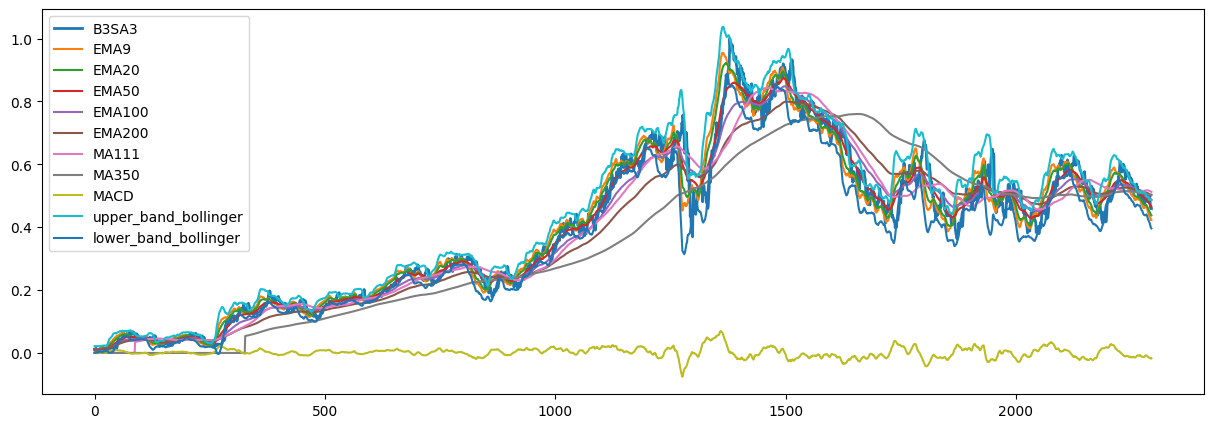

In [29]:
plt.figure(figsize=(15,5))
plt.plot(X[:,0],label=ticker,linewidth=2)
plt.plot(X[:,-len(features_indicators):])
plt.legend([ticker]+features_indicators)
plt.show()

In [30]:
# separa os dados em Treino e Teste
def split_data(X : np.array ,y : np.array, date_time : np.datetime64,factor=0.70):
    """Split the data in train validation or test

    Args:
        X (np.array): _description_
        y (np.array): _description_
        date_time (np.datetime64): _description_
        factor (float, optional): _description_. Defaults to 0.70.

    Returns:
        _type_: _description_
    """
    nits=round(len(X)*factor)

    X_train=X[:nits,:]

    nit_test= np.max(X_train.shape) -1
    X_test = X[nit_test:,:]

    y_train =y[:nits]
    y_test =y[nit_test:]

    T_train = date_time[:nits]
    T_test = date_time[nit_test:]
    
    return X_train,X_test, y_train, y_test, T_train, T_test

X_train,X_test, y_train, y_test, T_train, T_test=split_data(X,y,date_time, factor=0.85)

In [31]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=T_train ,y=np.squeeze(y_train), mode='lines',name="Dados de Treino"))
fig.add_trace(go.Scatter(x=T_test, y=np.squeeze(y_test), mode='lines',name="Dados de Teste"))
# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)
fig.show()

## Neural Networkt aproach

### Used Models

#### CNN_LSTM

In [32]:
from tensorflow.keras.initializers import RandomUniform, glorot_uniform, he_uniform

model_name= "CNN_LSTM"
np.random.seed(42)
def CNN_LSTM(data_input):
    # define model architecture
    model = Sequential()
   
    model.add(Conv1D(64, kernel_size=5, strides=2, activation='relu',input_shape=(X.shape[1],1), kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    #model.add(GRU(64, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    
    model.add(Dropout(0.2))
    model.add(Flatten())
    return model

def dense_layers(features, n_outputs=1, name=None):
    model=features

    # layer 2
    model.add( tf.keras.layers.Dense(32, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation(tf.keras.activations.relu))

    # layer 3 - Output Layer 
    model.add(tf.keras.layers.Dense(n_outputs))
    model.add(tf.keras.layers.Activation(tf.keras.activations.linear))
    return model

features = CNN_LSTM(X)
model_CNN_LSTM=dense_layers(features, n_outputs = pred_days)
model_CNN_LSTM._name=model_name
model_CNN_LSTM.summary()

2024-04-29 20:25:39.275971: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "CNN_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 15, 64)            384       
                                                                 
 batch_normalization (Batch  (None, 15, 64)            256       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 7, 64)             0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 7, 64)             0         
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense (Dense)               (None, 32)                143

#### MultiLayer Perceptron

In [33]:
# Model name
model_name = "MLP"

# Input layer
input_data = Input(shape=(X.shape[1],))

# Dense layer 1 with batch normalization
dense1 = Dense(64)(input_data)
bn1 = BatchNormalization()(dense1)
activation1 = Activation('relu')(bn1)

# Dense layer 2 with batch normalization and dropout
dense2 = Dense(128)(activation1)
bn2 = BatchNormalization()(dense2)
activation2 = Activation('relu')(bn2)
dropout2 = Dropout(0.2)(activation2)

# Output layer
output = Dense(1, activation='linear')(dropout2)

# Create the model
model_MLP = Model(inputs=input_data, outputs=output)
model_MLP._name = model_name

# Print model summary
model_MLP.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense_2 (Dense)             (None, 64)                2176      
                                                                 
 batch_normalization_2 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                              

#### Long Short-Term Memory (LSTM) 

In [34]:
model_name= "LSTM"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
lstm_output  = LSTM(64, return_sequences=False)(input_data)
bn_lstm = BatchNormalization()(lstm_output)
activation_lstm = Activation('relu')(bn_lstm)
Dropout_output = Dropout(0.2)(activation_lstm)

#lstm_output2  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output2)

#lstm_output3  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output3)

#lstm_output  = LSTM(4, activation='tanh')(Dropout_output)
#Dropout_output = Dropout(0.2)(lstm_output)

#dense_output = Dense(32, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)

#dense_output = Dense(8, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)
# Camada de saída
output = Dense(1, activation='linear')(Dropout_output)

model_LSTM = Model(inputs=input_data, outputs=output)
model_LSTM._name = model_name
model_LSTM.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 33, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 batch_normalization_4 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 64)                0         
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                              

#### Long Short-Term Memory (GRU) 

In [35]:
model_name= "GRU"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
GRU_output  = GRU(64)(input_data)

bn_lstm = BatchNormalization()(GRU_output)
activation_lstm = Activation('relu')(bn_lstm)
Dropout_output = Dropout(0.2)(activation_lstm)

output = Dense(pred_days, activation='linear')(Dropout_output)

model_GRU = Model(inputs=input_data, outputs=output)
model_GRU._name = model_name
model_GRU.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 33, 1)]           0         
                                                                 
 gru (GRU)                   (None, 64)                12864     
                                                                 
 batch_normalization_5 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (None, 64)                0         
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                               

#### LSTM with Attention layer

In [36]:
# Define the Attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # Apply attention weights to input
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector

In [37]:
model_name= "LSTM_AT"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

LSTM_output = tf.keras.layers.LSTM(64, return_sequences=True)(input_data)

bn_lstm = BatchNormalization()(LSTM_output)
activation_lstm = Activation('relu')(bn_lstm)
X = Dropout(0.2)(activation_lstm)

x = Attention(64)(X)
x = tf.keras.layers.Dense(pred_days)(x)

model_LSTM_AT = tf.keras.Model(inputs=input_data, outputs=x)
model_LSTM_AT._name = model_name

model_LSTM_AT.summary()

Model: "LSTM_AT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 33, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 33, 64)            16896     
                                                                 
 batch_normalization_6 (Bat  (None, 33, 64)            256       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 33, 64)            0         
                                                                 
 dropout_4 (Dropout)         (None, 33, 64)            0         
                                                                 
 attention (Attention)       (None, 64)                4225      
                                                           

### Hyperparams and trainnig

**Metrics and Loss Functions**  

In [38]:
from tensorflow.keras import backend as K

def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot - K.epsilon()) )

def NRMSE(y_true, y_pred): # normalized_root_mean_squared_error
    return 1-K.sqrt(K.mean(K.square(y_pred - y_true))) 

MSE= tf.keras.losses.mean_squared_error
MAE = tf.keras.losses.mean_absolute_error
MAPE = tf.keras.losses.mean_absolute_percentage_error

**Optimizers**  

In [39]:
def get_optimizer():
    optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True, name="Adam")
    return optimizer1
    #optimizer2 = tf.keras.optimizers.RMSprop(learning_rate=0.05)

**Train options callbacks**  

In [40]:
# Avalia se está tendo avanção de desempenho no treinamento/validação e para caso não tenha avanço 
EarlyStopping=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=10, verbose=1, mode="min", restore_best_weights=True,)

# verifica se está tendo avanço de desempenho durante o treinamento, caso não reduz integralmente o lr
reduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 5, min_lr=1e-14,verbose=1)


checkpoint_filepath = './models_checkpoint/'
checkpoint_filepath =f'models/{model_name}_{ticker}_{lookback}_ex1'


def checkpoints(model_name):
    checkpoint_filepath =f'models/model_{model_name}_stock_{ticker}_lookback_{lookback}'
    csvLogger = tf.keras.callbacks.CSVLogger(checkpoint_filepath+'_history.csv', separator=',',append=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
    print("Training model :", checkpoint_filepath)

    return csvLogger, model_checkpoint_callback

### Models train

Training model : models/model_MLP_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: MLP
Epoch 1/200
38/43 [=========================>....] - ETA: 0s - loss: 0.8662 - NRMSE: 0.3219 
Epoch 1: val_loss improved from inf to 1.96373, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 4s 54ms/step - loss: 0.7762 - NRMSE: 0.3776 - val_loss: 1.9637 - val_NRMSE: -0.3350 - lr: 0.0500
Epoch 2/200
37/43 [========================>.....] - ETA: 0s - loss: 0.0270 - NRMSE: 0.8432
Epoch 2: val_loss improved from 1.96373 to 0.07799, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 2s 40ms/step - loss: 0.0259 - NRMSE: 0.8464 - val_loss: 0.0780 - val_NRMSE: 0.7307 - lr: 0.0500
Epoch 3/200
36/43 [========================>.....] - ETA: 0s - loss: 0.0091 - NRMSE: 0.9089
Epoch 3: val_loss improved from 0.07799 to 0.06206, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 2s 38ms/step - loss: 0.0089 - NRMSE: 0.9093 - val_loss: 0.0621 - val_NRMSE: 0.7606 - lr: 0.0500
Epoch 4/200
33/43 [======================>.......] - ETA: 0s - loss: 0.0068 - NRMSE: 0.9209
Epoch 4: val_loss improved from 0.06206 to 0.04374, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 2s 37ms/step - loss: 0.0071 - NRMSE: 0.9197 - val_loss: 0.0437 - val_NRMSE: 0.8092 - lr: 0.0500
Epoch 5/200
38/43 [=========================>....] - ETA: 0s - loss: 0.0079 - NRMSE: 0.9167
Epoch 5: val_loss did not improve from 0.04374
43/43 [==============================] - 0s 4ms/step - loss: 0.0076 - NRMSE: 0.9180 - val_loss: 0.0532 - val_NRMSE: 0.7861 - lr: 0.0500
Epoch 6/200
36/43 [========================>.....] - ETA: 0s - loss: 0.0055 - NRMSE: 0.9298
Epoch 6: val_loss improved from 0.04374 to 0.00210, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 1s 35ms/step - loss: 0.0052 - NRMSE: 0.9320 - val_loss: 0.0021 - val_NRMSE: 0.9572 - lr: 0.0500
Epoch 7/200
41/43 [===========================>..] - ETA: 0s - loss: 0.0051 - NRMSE: 0.9317
Epoch 7: val_loss improved from 0.00210 to 0.00114, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 1s 28ms/step - loss: 0.0051 - NRMSE: 0.9322 - val_loss: 0.0011 - val_NRMSE: 0.9677 - lr: 0.0500
Epoch 8/200
35/43 [=======================>......] - ETA: 0s - loss: 0.0035 - NRMSE: 0.9436
Epoch 8: val_loss did not improve from 0.00114
43/43 [==============================] - 0s 2ms/step - loss: 0.0034 - NRMSE: 0.9438 - val_loss: 0.0057 - val_NRMSE: 0.9337 - lr: 0.0500
Epoch 9/200
34/43 [======================>.......] - ETA: 0s - loss: 0.0038 - NRMSE: 0.9421
Epoch 9: val_loss did not improve from 0.00114
43/43 [==============================] - 0s 2ms/step - loss: 0.0036 - NRMSE: 0.9433 - val_loss: 0.0075 - val_NRMSE: 0.9211 - lr: 0.0500
Epoch 10/200
33/43 [======================>.......] - ETA: 0s - loss: 0.0042 - NRMSE: 0.9385
Epoch 10: val_loss did not improve from 0.00114
43/43 [==============================] - 0s 2ms/step - loss: 0.0049 - NRMSE: 0.9344 - val_loss: 0.0122 - val_NRMSE: 0.8935 - lr: 0.0500
Epoch 11/200
34/43 [================

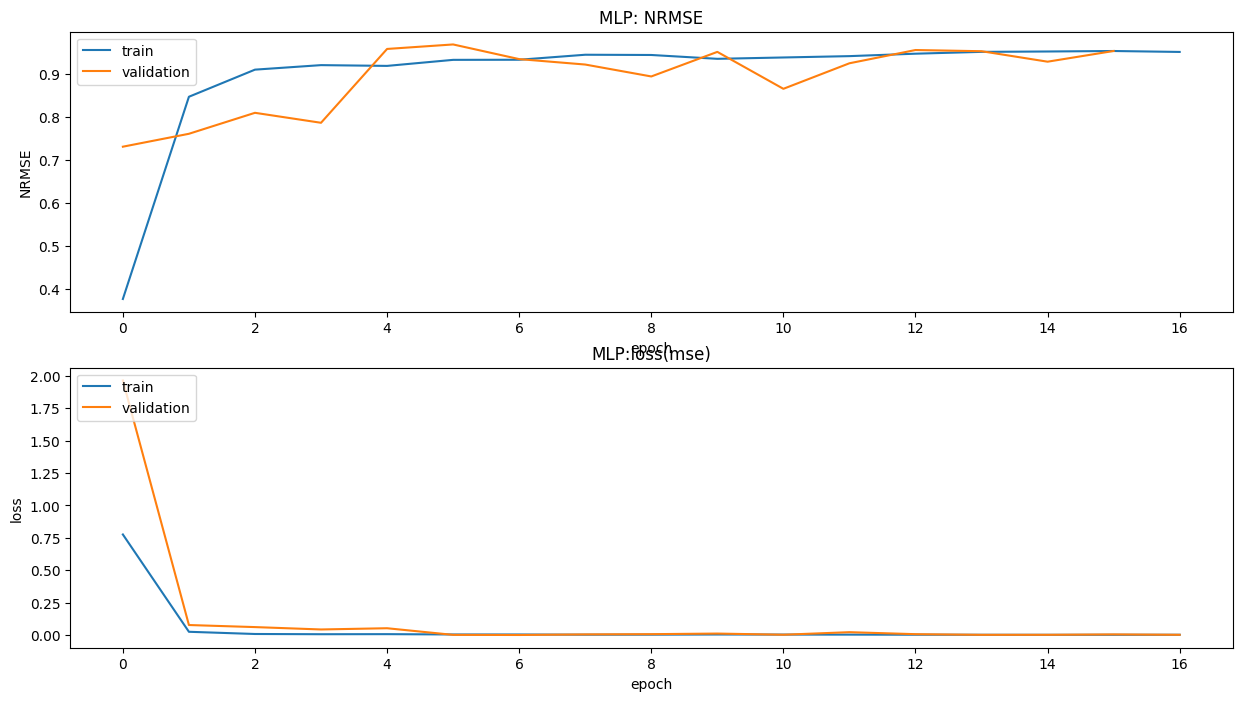

Training model : models/model_GRU_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: GRU
Epoch 1/200
41/43 [===========================>..] - ETA: 0s - loss: 0.1498 - NRMSE: 0.7326
Epoch 1: val_loss improved from inf to 0.14034, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 5s 85ms/step - loss: 0.1443 - NRMSE: 0.7414 - val_loss: 0.1403 - val_NRMSE: 0.6590 - lr: 0.0500
Epoch 2/200
40/43 [==========================>...] - ETA: 0s - loss: 0.0071 - NRMSE: 0.9189
Epoch 2: val_loss improved from 0.14034 to 0.12888, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 3s 64ms/step - loss: 0.0067 - NRMSE: 0.9217 - val_loss: 0.1289 - val_NRMSE: 0.6764 - lr: 0.0500
Epoch 3/200
42/43 [============================>.] - ETA: 0s - loss: 0.0046 - NRMSE: 0.9361
Epoch 3: val_loss improved from 0.12888 to 0.10309, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 4s 88ms/step - loss: 0.0047 - NRMSE: 0.9350 - val_loss: 0.1031 - val_NRMSE: 0.7165 - lr: 0.0500
Epoch 4/200
40/43 [==========================>...] - ETA: 0s - loss: 0.0055 - NRMSE: 0.9305
Epoch 4: val_loss improved from 0.10309 to 0.08851, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 4s 91ms/step - loss: 0.0056 - NRMSE: 0.9289 - val_loss: 0.0885 - val_NRMSE: 0.7407 - lr: 0.0500
Epoch 5/200
41/43 [===========================>..] - ETA: 0s - loss: 0.0061 - NRMSE: 0.9262
Epoch 5: val_loss did not improve from 0.08851
43/43 [==============================] - 1s 14ms/step - loss: 0.0060 - NRMSE: 0.9265 - val_loss: 0.1170 - val_NRMSE: 0.6919 - lr: 0.0500
Epoch 6/200
39/43 [==========================>...] - ETA: 0s - loss: 0.0060 - NRMSE: 0.9263
Epoch 6: val_loss did not improve from 0.08851
43/43 [==============================] - 1s 16ms/step - loss: 0.0060 - NRMSE: 0.9260 - val_loss: 0.1307 - val_NRMSE: 0.6719 - lr: 0.0500
Epoch 7/200
40/43 [==========================>...] - ETA: 0s - loss: 0.0065 - NRMSE: 0.9258
Epoch 7: val_loss improved from 0.08851 to 0.06825, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 4s 90ms/step - loss: 0.0064 - NRMSE: 0.9269 - val_loss: 0.0682 - val_NRMSE: 0.7760 - lr: 0.0500
Epoch 8/200
41/43 [===========================>..] - ETA: 0s - loss: 0.0034 - NRMSE: 0.9437
Epoch 8: val_loss did not improve from 0.06825
43/43 [==============================] - 1s 16ms/step - loss: 0.0033 - NRMSE: 0.9442 - val_loss: 0.0812 - val_NRMSE: 0.7502 - lr: 0.0500
Epoch 9/200
40/43 [==========================>...] - ETA: 0s - loss: 0.0036 - NRMSE: 0.9425
Epoch 9: val_loss did not improve from 0.06825
43/43 [==============================] - 1s 16ms/step - loss: 0.0037 - NRMSE: 0.9417 - val_loss: 0.0796 - val_NRMSE: 0.7527 - lr: 0.0500
Epoch 10/200
39/43 [==========================>...] - ETA: 0s - loss: 0.0047 - NRMSE: 0.9359
Epoch 10: val_loss did not improve from 0.06825
43/43 [==============================] - 1s 14ms/step - loss: 0.0050 - NRMSE: 0.9341 - val_loss: 0.0874 - val_NRMSE: 0.7341 - lr: 0.0500
Epoch 11/200
40/43 [=============

INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 3s 83ms/step - loss: 0.0048 - NRMSE: 0.9358 - val_loss: 0.0478 - val_NRMSE: 0.8084 - lr: 0.0500
Epoch 12/200
42/43 [============================>.] - ETA: 0s - loss: 0.0044 - NRMSE: 0.9387
Epoch 12: val_loss improved from 0.04784 to 0.03094, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 3s 64ms/step - loss: 0.0044 - NRMSE: 0.9384 - val_loss: 0.0309 - val_NRMSE: 0.8525 - lr: 0.0500
Epoch 13/200
40/43 [==========================>...] - ETA: 0s - loss: 0.0041 - NRMSE: 0.9395
Epoch 13: val_loss improved from 0.03094 to 0.02051, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 4s 96ms/step - loss: 0.0042 - NRMSE: 0.9387 - val_loss: 0.0205 - val_NRMSE: 0.8833 - lr: 0.0500
Epoch 14/200
39/43 [==========================>...] - ETA: 0s - loss: 0.0042 - NRMSE: 0.9384
Epoch 14: val_loss improved from 0.02051 to 0.00325, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 4s 83ms/step - loss: 0.0044 - NRMSE: 0.9379 - val_loss: 0.0032 - val_NRMSE: 0.9474 - lr: 0.0500
Epoch 15/200
42/43 [============================>.] - ETA: 0s - loss: 0.0040 - NRMSE: 0.9391
Epoch 15: val_loss did not improve from 0.00325
43/43 [==============================] - 1s 15ms/step - loss: 0.0041 - NRMSE: 0.9384 - val_loss: 0.0120 - val_NRMSE: 0.9108 - lr: 0.0500
Epoch 16/200
41/43 [===========================>..] - ETA: 0s - loss: 0.0054 - NRMSE: 0.9301
Epoch 16: val_loss did not improve from 0.00325
43/43 [==============================] - 1s 16ms/step - loss: 0.0053 - NRMSE: 0.9306 - val_loss: 0.0310 - val_NRMSE: 0.8311 - lr: 0.0500
Epoch 17/200
41/43 [===========================>..] - ETA: 0s - loss: 0.0034 - NRMSE: 0.9436
Epoch 17: val_loss did not improve from 0.00325
43/43 [==============================] - 1s 15ms/step - loss: 0.0035 - NRMSE: 0.9432 - val_loss: 0.1330 - val_NRMSE: 0.6374 - lr: 0.0500
Epoch 18/200
40/43 [=========

INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 4s 85ms/step - loss: 0.0027 - NRMSE: 0.9504 - val_loss: 0.0020 - val_NRMSE: 0.9569 - lr: 0.0100
Epoch 23/200
40/43 [==========================>...] - ETA: 0s - loss: 0.0024 - NRMSE: 0.9533
Epoch 23: val_loss did not improve from 0.00204
43/43 [==============================] - 1s 15ms/step - loss: 0.0025 - NRMSE: 0.9529 - val_loss: 0.0066 - val_NRMSE: 0.9232 - lr: 0.0100
Epoch 24/200
42/43 [============================>.] - ETA: 0s - loss: 0.0024 - NRMSE: 0.9528
Epoch 24: val_loss did not improve from 0.00204
43/43 [==============================] - 1s 15ms/step - loss: 0.0024 - NRMSE: 0.9526 - val_loss: 0.0132 - val_NRMSE: 0.8896 - lr: 0.0100
Epoch 25/200
40/43 [==========================>...] - ETA: 0s - loss: 0.0028 - NRMSE: 0.9492
Epoch 25: val_loss did not improve from 0.00204
43/43 [==============================] - 1s 15ms/step - loss: 0.0029 - NRMSE: 0.9485 - val_loss: 0.0043 - val_NRMSE: 0.9375 - lr: 0.0100
Epoch 26/200
40/43 [=========

INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 4s 95ms/step - loss: 0.0021 - NRMSE: 0.9560 - val_loss: 0.0015 - val_NRMSE: 0.9626 - lr: 0.0020
Epoch 29/200
41/43 [===========================>..] - ETA: 0s - loss: 0.0027 - NRMSE: 0.9507
Epoch 29: val_loss improved from 0.00150 to 0.00145, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 3s 80ms/step - loss: 0.0027 - NRMSE: 0.9506 - val_loss: 0.0014 - val_NRMSE: 0.9627 - lr: 0.0020
Epoch 30/200
39/43 [==========================>...] - ETA: 0s - loss: 0.0027 - NRMSE: 0.9519
Epoch 30: val_loss did not improve from 0.00145
43/43 [==============================] - 1s 17ms/step - loss: 0.0027 - NRMSE: 0.9515 - val_loss: 0.0030 - val_NRMSE: 0.9480 - lr: 0.0020
Epoch 31/200
41/43 [===========================>..] - ETA: 0s - loss: 0.0028 - NRMSE: 0.9500
Epoch 31: val_loss did not improve from 0.00145
43/43 [==============================] - 1s 13ms/step - loss: 0.0028 - NRMSE: 0.9498 - val_loss: 0.0015 - val_NRMSE: 0.9623 - lr: 0.0020
Epoch 32/200
42/43 [============================>.] - ETA: 0s - loss: 0.0025 - NRMSE: 0.9527
Epoch 32: val_loss improved from 0.00145 to 0.00141, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 3s 82ms/step - loss: 0.0025 - NRMSE: 0.9521 - val_loss: 0.0014 - val_NRMSE: 0.9630 - lr: 0.0020
Epoch 33/200
39/43 [==========================>...] - ETA: 0s - loss: 0.0023 - NRMSE: 0.9558
Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.

Epoch 33: val_loss did not improve from 0.00141
43/43 [==============================] - 1s 17ms/step - loss: 0.0023 - NRMSE: 0.9553 - val_loss: 0.0024 - val_NRMSE: 0.9533 - lr: 0.0020
Epoch 34/200
42/43 [============================>.] - ETA: 0s - loss: 0.0021 - NRMSE: 0.9565
Epoch 34: val_loss did not improve from 0.00141
43/43 [==============================] - 1s 17ms/step - loss: 0.0021 - NRMSE: 0.9567 - val_loss: 0.0025 - val_NRMSE: 0.9528 - lr: 4.0000e-04
Epoch 35/200
41/43 [===========================>..] - ETA: 0s - loss: 0.0026 - NRMSE: 0.9520
Epoch 35: val_loss did not improve from 0.00141
43/43 [==============================] - 1s 18ms/step - loss: 0.0026 - NRMSE: 0.9522

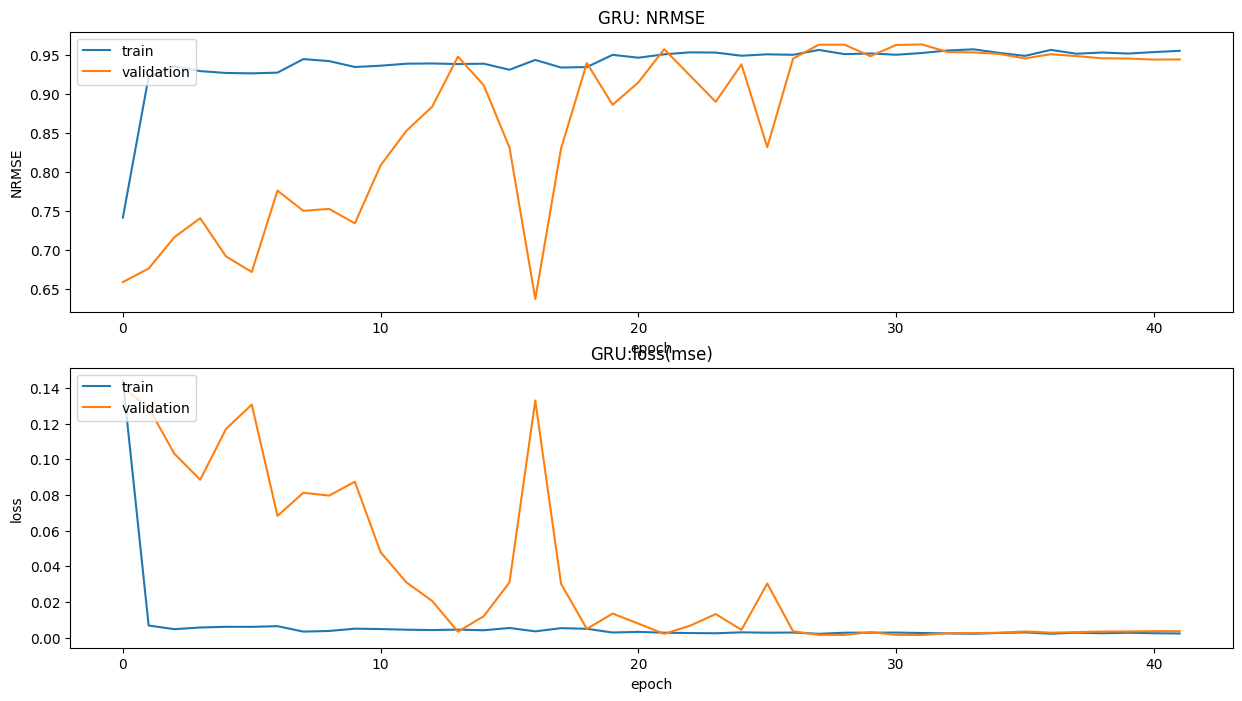

Training model : models/model_CNN_LSTM_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: CNN_LSTM
Epoch 1/200
40/43 [==========================>...] - ETA: 0s - loss: 0.1413 - NRMSE: 0.7163 
Epoch 1: val_loss improved from inf to 0.44473, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 3s 40ms/step - loss: 0.1335 - NRMSE: 0.7287 - val_loss: 0.4447 - val_NRMSE: 0.3506 - lr: 0.0500
Epoch 2/200
40/43 [==========================>...] - ETA: 0s - loss: 0.0073 - NRMSE: 0.9178
Epoch 2: val_loss improved from 0.44473 to 0.07743, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 2s 36ms/step - loss: 0.0071 - NRMSE: 0.9188 - val_loss: 0.0774 - val_NRMSE: 0.7257 - lr: 0.0500
Epoch 3/200
35/43 [=======================>......] - ETA: 0s - loss: 0.0054 - NRMSE: 0.9314
Epoch 3: val_loss improved from 0.07743 to 0.01774, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 2s 39ms/step - loss: 0.0055 - NRMSE: 0.9319 - val_loss: 0.0177 - val_NRMSE: 0.8784 - lr: 0.0500
Epoch 4/200
38/43 [=========================>....] - ETA: 0s - loss: 0.0067 - NRMSE: 0.9230
Epoch 4: val_loss did not improve from 0.01774
43/43 [==============================] - 0s 10ms/step - loss: 0.0065 - NRMSE: 0.9236 - val_loss: 0.0321 - val_NRMSE: 0.8360 - lr: 0.0500
Epoch 5/200
43/43 [==============================] - ETA: 0s - loss: 0.0040 - NRMSE: 0.9410
Epoch 5: val_loss did not improve from 0.01774
43/43 [==============================] - 0s 9ms/step - loss: 0.0040 - NRMSE: 0.9410 - val_loss: 0.0347 - val_NRMSE: 0.8342 - lr: 0.0500
Epoch 6/200
38/43 [=========================>....] - ETA: 0s - loss: 0.0037 - NRMSE: 0.9447
Epoch 6: val_loss improved from 0.01774 to 0.00889, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 2s 38ms/step - loss: 0.0045 - NRMSE: 0.9411 - val_loss: 0.0089 - val_NRMSE: 0.9166 - lr: 0.0500
Epoch 7/200
37/43 [========================>.....] - ETA: 0s - loss: 0.0072 - NRMSE: 0.9240
Epoch 7: val_loss did not improve from 0.00889
43/43 [==============================] - 0s 6ms/step - loss: 0.0072 - NRMSE: 0.9242 - val_loss: 0.0801 - val_NRMSE: 0.7469 - lr: 0.0500
Epoch 8/200
41/43 [===========================>..] - ETA: 0s - loss: 0.0052 - NRMSE: 0.9331
Epoch 8: val_loss did not improve from 0.00889
43/43 [==============================] - 0s 5ms/step - loss: 0.0053 - NRMSE: 0.9320 - val_loss: 0.0216 - val_NRMSE: 0.8697 - lr: 0.0500
Epoch 9/200
30/43 [===================>..........] - ETA: 0s - loss: 0.0085 - NRMSE: 0.9150
Epoch 9: val_loss did not improve from 0.00889
43/43 [==============================] - 0s 5ms/step - loss: 0.0079 - NRMSE: 0.9200 - val_loss: 0.0131 - val_NRMSE: 0.9053 - lr: 0.0500
Epoch 10/200
36/43 [==================

INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 2s 44ms/step - loss: 0.0043 - NRMSE: 0.9409 - val_loss: 0.0071 - val_NRMSE: 0.9317 - lr: 0.0500
Epoch 12/200
43/43 [==============================] - ETA: 0s - loss: 0.0053 - NRMSE: 0.9349  
Epoch 12: val_loss did not improve from 0.00713
43/43 [==============================] - 0s 5ms/step - loss: 0.0053 - NRMSE: 0.9349 - val_loss: 0.0591 - val_NRMSE: 0.7955 - lr: 0.0500
Epoch 13/200
32/43 [=====================>........] - ETA: 0s - loss: 0.0076 - NRMSE: 0.9239
Epoch 13: val_loss did not improve from 0.00713
43/43 [==============================] - 0s 5ms/step - loss: 0.0069 - NRMSE: 0.9276 - val_loss: 0.0141 - val_NRMSE: 0.9075 - lr: 0.0500
Epoch 14/200
42/43 [============================>.] - ETA: 0s - loss: 0.0036 - NRMSE: 0.9447
Epoch 14: val_loss did not improve from 0.00713
43/43 [==============================] - 0s 5ms/step - loss: 0.0036 - NRMSE: 0.9447 - val_loss: 0.0379 - val_NRMSE: 0.8341 - lr: 0.0500
Epoch 15/200
42/43 [==========

INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 1s 34ms/step - loss: 0.0018 - NRMSE: 0.9604 - val_loss: 0.0034 - val_NRMSE: 0.9488 - lr: 0.0100
Epoch 18/200
40/43 [==========================>...] - ETA: 0s - loss: 0.0015 - NRMSE: 0.9632
Epoch 18: val_loss did not improve from 0.00338
43/43 [==============================] - 0s 5ms/step - loss: 0.0015 - NRMSE: 0.9627 - val_loss: 0.0130 - val_NRMSE: 0.9098 - lr: 0.0100
Epoch 19/200
34/43 [======================>.......] - ETA: 0s - loss: 0.0019 - NRMSE: 0.9590
Epoch 19: val_loss did not improve from 0.00338
43/43 [==============================] - 0s 4ms/step - loss: 0.0020 - NRMSE: 0.9574 - val_loss: 0.0048 - val_NRMSE: 0.9429 - lr: 0.0100
Epoch 20/200
32/43 [=====================>........] - ETA: 0s - loss: 0.0017 - NRMSE: 0.9608
Epoch 20: val_loss improved from 0.00338 to 0.00144, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 1s 34ms/step - loss: 0.0017 - NRMSE: 0.9607 - val_loss: 0.0014 - val_NRMSE: 0.9632 - lr: 0.0100
Epoch 21/200
39/43 [==========================>...] - ETA: 0s - loss: 0.0019 - NRMSE: 0.9583
Epoch 21: val_loss did not improve from 0.00144
43/43 [==============================] - 0s 6ms/step - loss: 0.0019 - NRMSE: 0.9584 - val_loss: 0.0074 - val_NRMSE: 0.9302 - lr: 0.0100
Epoch 22/200
40/43 [==========================>...] - ETA: 0s - loss: 0.0018 - NRMSE: 0.9607   
Epoch 22: val_loss did not improve from 0.00144
43/43 [==============================] - 0s 4ms/step - loss: 0.0017 - NRMSE: 0.9610 - val_loss: 0.0015 - val_NRMSE: 0.9630 - lr: 0.0100
Epoch 23/200
33/43 [======================>.......] - ETA: 0s - loss: 0.0018 - NRMSE: 0.9591
Epoch 23: val_loss did not improve from 0.00144
43/43 [==============================] - 0s 4ms/step - loss: 0.0021 - NRMSE: 0.9564 - val_loss: 0.0128 - val_NRMSE: 0.8890 - lr: 0.0100
Epoch 24/200
33/43 [=========

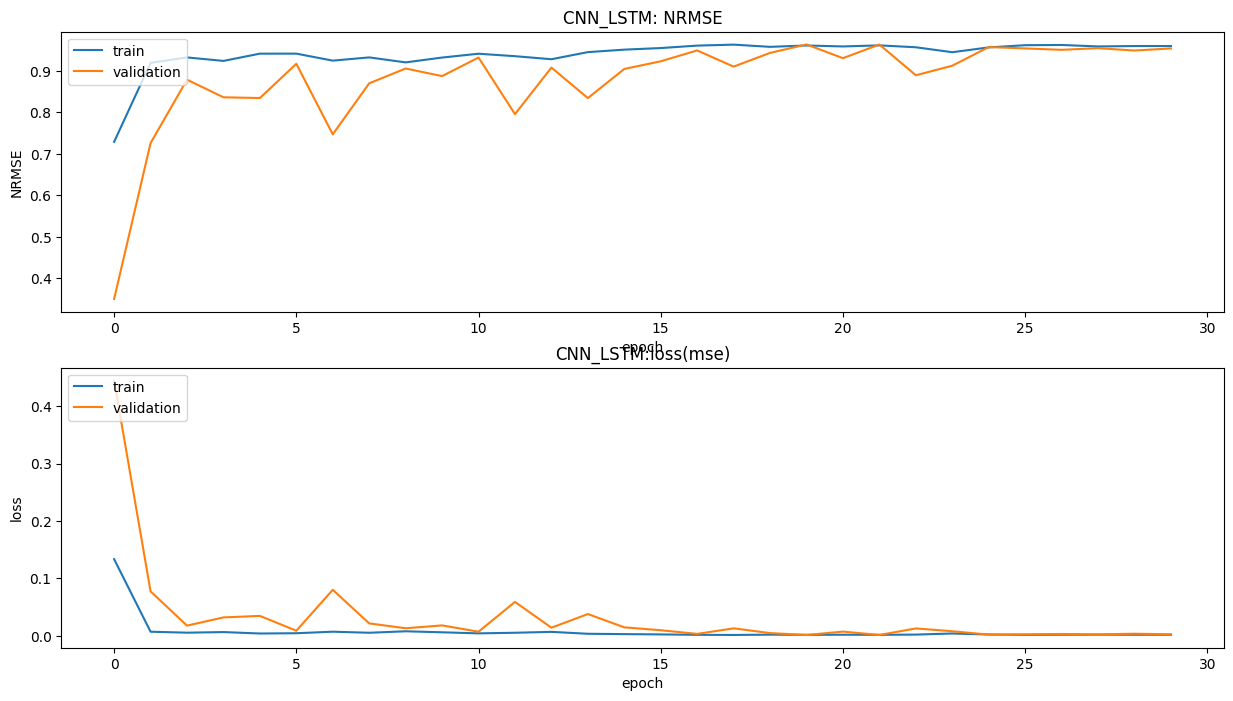

Training model : models/model_LSTM_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: LSTM
Epoch 1/200
38/43 [=========================>....] - ETA: 0s - loss: 0.1743 - NRMSE: 0.7378
Epoch 1: val_loss improved from inf to 0.11460, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 7s 105ms/step - loss: 0.1559 - NRMSE: 0.7599 - val_loss: 0.1146 - val_NRMSE: 0.6996 - lr: 0.0500
Epoch 2/200
39/43 [==========================>...] - ETA: 0s - loss: 0.0049 - NRMSE: 0.9324
Epoch 2: val_loss did not improve from 0.11460
43/43 [==============================] - 1s 18ms/step - loss: 0.0047 - NRMSE: 0.9333 - val_loss: 0.1247 - val_NRMSE: 0.6834 - lr: 0.0500
Epoch 3/200
40/43 [==========================>...] - ETA: 0s - loss: 0.0047 - NRMSE: 0.9328
Epoch 3: val_loss improved from 0.11460 to 0.09620, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 4s 87ms/step - loss: 0.0047 - NRMSE: 0.9330 - val_loss: 0.0962 - val_NRMSE: 0.7286 - lr: 0.0500
Epoch 4/200
41/43 [===========================>..] - ETA: 0s - loss: 0.0041 - NRMSE: 0.9382
Epoch 4: val_loss improved from 0.09620 to 0.08961, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 4s 90ms/step - loss: 0.0042 - NRMSE: 0.9372 - val_loss: 0.0896 - val_NRMSE: 0.7396 - lr: 0.0500
Epoch 5/200
41/43 [===========================>..] - ETA: 0s - loss: 0.0062 - NRMSE: 0.9260
Epoch 5: val_loss improved from 0.08961 to 0.05365, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 4s 98ms/step - loss: 0.0063 - NRMSE: 0.9248 - val_loss: 0.0537 - val_NRMSE: 0.8104 - lr: 0.0500
Epoch 6/200
42/43 [============================>.] - ETA: 0s - loss: 0.0049 - NRMSE: 0.9333
Epoch 6: val_loss did not improve from 0.05365
43/43 [==============================] - 1s 15ms/step - loss: 0.0049 - NRMSE: 0.9330 - val_loss: 0.0937 - val_NRMSE: 0.7281 - lr: 0.0500
Epoch 7/200
40/43 [==========================>...] - ETA: 0s - loss: 0.0041 - NRMSE: 0.9393
Epoch 7: val_loss did not improve from 0.05365
43/43 [==============================] - 1s 14ms/step - loss: 0.0043 - NRMSE: 0.9375 - val_loss: 0.0608 - val_NRMSE: 0.7898 - lr: 0.0500
Epoch 8/200
42/43 [============================>.] - ETA: 0s - loss: 0.0049 - NRMSE: 0.9338
Epoch 8: val_loss did not improve from 0.05365
43/43 [==============================] - 1s 16ms/step - loss: 0.0049 - NRMSE: 0.9334 - val_loss: 0.0874 - val_NRMSE: 0.7371 - lr: 0.0500
Epoch 9/200
41/43 [================

INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 4s 87ms/step - loss: 0.0040 - NRMSE: 0.9404 - val_loss: 0.0448 - val_NRMSE: 0.8131 - lr: 0.0100
Epoch 12/200
41/43 [===========================>..] - ETA: 0s - loss: 0.0032 - NRMSE: 0.9451
Epoch 12: val_loss improved from 0.04484 to 0.03603, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 4s 90ms/step - loss: 0.0032 - NRMSE: 0.9452 - val_loss: 0.0360 - val_NRMSE: 0.8313 - lr: 0.0100
Epoch 13/200
41/43 [===========================>..] - ETA: 0s - loss: 0.0033 - NRMSE: 0.9447
Epoch 13: val_loss improved from 0.03603 to 0.02891, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 4s 99ms/step - loss: 0.0033 - NRMSE: 0.9452 - val_loss: 0.0289 - val_NRMSE: 0.8490 - lr: 0.0100
Epoch 14/200
41/43 [===========================>..] - ETA: 0s - loss: 0.0040 - NRMSE: 0.9395
Epoch 14: val_loss improved from 0.02891 to 0.01917, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 4s 92ms/step - loss: 0.0040 - NRMSE: 0.9389 - val_loss: 0.0192 - val_NRMSE: 0.8778 - lr: 0.0100
Epoch 15/200
41/43 [===========================>..] - ETA: 0s - loss: 0.0044 - NRMSE: 0.9371
Epoch 15: val_loss improved from 0.01917 to 0.01840, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 4s 92ms/step - loss: 0.0043 - NRMSE: 0.9378 - val_loss: 0.0184 - val_NRMSE: 0.8799 - lr: 0.0100
Epoch 16/200
42/43 [============================>.] - ETA: 0s - loss: 0.0034 - NRMSE: 0.9440
Epoch 16: val_loss improved from 0.01840 to 0.01309, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 3s 77ms/step - loss: 0.0034 - NRMSE: 0.9439 - val_loss: 0.0131 - val_NRMSE: 0.8945 - lr: 0.0100
Epoch 17/200
43/43 [==============================] - ETA: 0s - loss: 0.0042 - NRMSE: 0.9391
Epoch 17: val_loss improved from 0.01309 to 0.00768, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 2s 49ms/step - loss: 0.0042 - NRMSE: 0.9391 - val_loss: 0.0077 - val_NRMSE: 0.9199 - lr: 0.0100
Epoch 18/200
41/43 [===========================>..] - ETA: 0s - loss: 0.0036 - NRMSE: 0.9420
Epoch 18: val_loss improved from 0.00768 to 0.00471, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 3s 61ms/step - loss: 0.0036 - NRMSE: 0.9414 - val_loss: 0.0047 - val_NRMSE: 0.9371 - lr: 0.0100
Epoch 19/200
38/43 [=========================>....] - ETA: 0s - loss: 0.0035 - NRMSE: 0.9434
Epoch 19: val_loss improved from 0.00471 to 0.00189, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 2s 51ms/step - loss: 0.0037 - NRMSE: 0.9424 - val_loss: 0.0019 - val_NRMSE: 0.9601 - lr: 0.0100
Epoch 20/200
43/43 [==============================] - ETA: 0s - loss: 0.0042 - NRMSE: 0.9376
Epoch 20: val_loss improved from 0.00189 to 0.00171, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 2s 53ms/step - loss: 0.0042 - NRMSE: 0.9376 - val_loss: 0.0017 - val_NRMSE: 0.9613 - lr: 0.0100
Epoch 21/200
39/43 [==========================>...] - ETA: 0s - loss: 0.0037 - NRMSE: 0.9417
Epoch 21: val_loss did not improve from 0.00171
43/43 [==============================] - 0s 11ms/step - loss: 0.0039 - NRMSE: 0.9406 - val_loss: 0.0030 - val_NRMSE: 0.9472 - lr: 0.0100
Epoch 22/200
42/43 [============================>.] - ETA: 0s - loss: 0.0041 - NRMSE: 0.9389
Epoch 22: val_loss did not improve from 0.00171
43/43 [==============================] - 0s 11ms/step - loss: 0.0041 - NRMSE: 0.9391 - val_loss: 0.0020 - val_NRMSE: 0.9596 - lr: 0.0100
Epoch 23/200
38/43 [=========================>....] - ETA: 0s - loss: 0.0037 - NRMSE: 0.9418
Epoch 23: val_loss did not improve from 0.00171
43/43 [==============================] - 1s 13ms/step - loss: 0.0037 - NRMSE: 0.9419 - val_loss: 0.0027 - val_NRMSE: 0.9514 - lr: 0.0100
Epoch 24/200
41/43 [=========

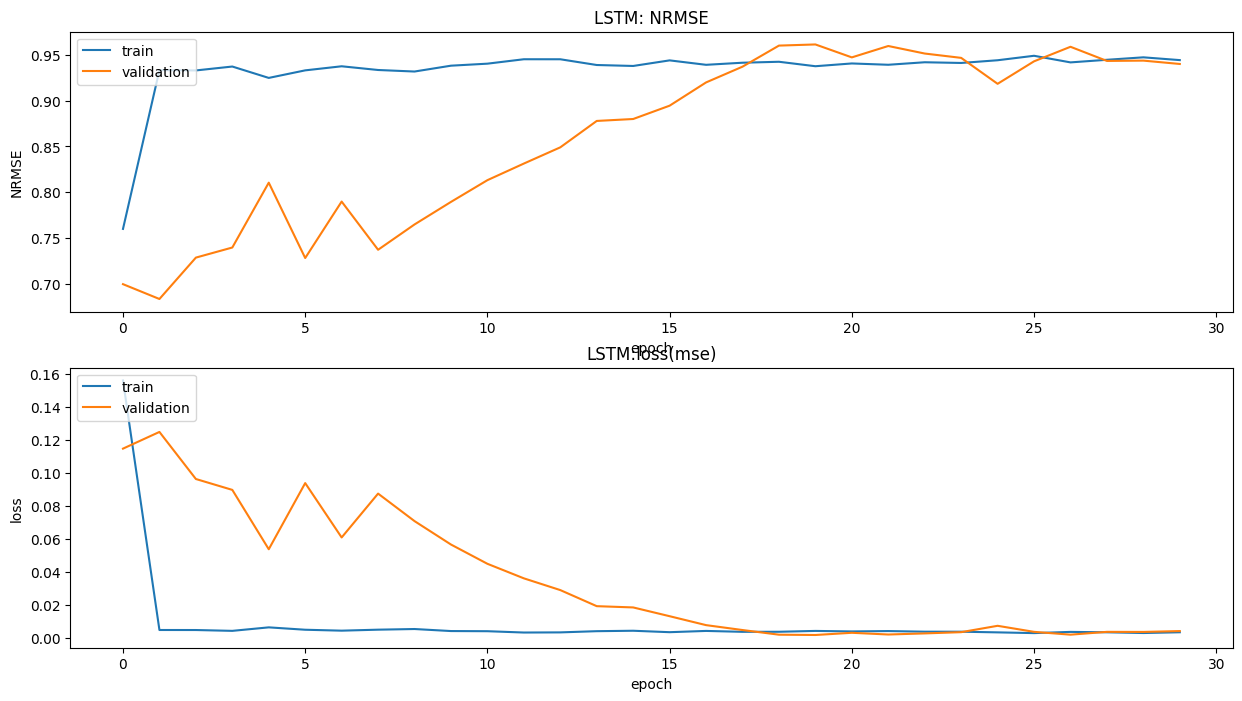

Training model : models/model_LSTM_AT_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: LSTM_AT
Epoch 1/200
40/43 [==========================>...] - ETA: 0s - loss: 0.2323 - NRMSE: 0.6601
Epoch 1: val_loss improved from inf to 0.01861, saving model to models/model_LSTM_AT_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 5s 75ms/step - loss: 0.2198 - NRMSE: 0.6729 - val_loss: 0.0186 - val_NRMSE: 0.8715 - lr: 0.0500
Epoch 2/200
41/43 [===========================>..] - ETA: 0s - loss: 0.0103 - NRMSE: 0.9037
Epoch 2: val_loss did not improve from 0.01861
43/43 [==============================] - 1s 13ms/step - loss: 0.0103 - NRMSE: 0.9036 - val_loss: 0.0188 - val_NRMSE: 0.8891 - lr: 0.0500
Epoch 3/200
41/43 [===========================>..] - ETA: 0s - loss: 0.0046 - NRMSE: 0.9346
Epoch 3: val_loss did not improve from 0.01861
43/43 [==============================] - 1s 13ms/step - loss: 0.0046 - NRMSE: 0.9344 - val_loss: 0.0489 - val_NRMSE: 0.8107 - lr: 0.0500
Epoch 4/200
41/43 [===========================>..] - ETA: 0s - loss: 0.0048 - NRMSE: 0.9341
Epoch 4: val_loss did not improve from 0.01861
43/43 [==============================] - 1s 14ms/step - loss: 0.0048 - NRMSE: 0.9344 - val_loss: 0.0412 - val_NRMSE: 0.8198 - lr: 0.0500
Epoch 5/200
41/43 [================

INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


43/43 [==============================] - 3s 61ms/step - loss: 0.0054 - NRMSE: 0.9317 - val_loss: 0.0119 - val_NRMSE: 0.8966 - lr: 0.0500
Epoch 6/200
41/43 [===========================>..] - ETA: 0s - loss: 0.0048 - NRMSE: 0.9344
Epoch 6: val_loss did not improve from 0.01187
43/43 [==============================] - 1s 13ms/step - loss: 0.0048 - NRMSE: 0.9344 - val_loss: 0.0250 - val_NRMSE: 0.8597 - lr: 0.0500
Epoch 7/200
41/43 [===========================>..] - ETA: 0s - loss: 0.0039 - NRMSE: 0.9416
Epoch 7: val_loss did not improve from 0.01187
43/43 [==============================] - 1s 13ms/step - loss: 0.0038 - NRMSE: 0.9420 - val_loss: 0.0140 - val_NRMSE: 0.8991 - lr: 0.0500
Epoch 8/200
41/43 [===========================>..] - ETA: 0s - loss: 0.0031 - NRMSE: 0.9470
Epoch 8: val_loss did not improve from 0.01187
43/43 [==============================] - 1s 13ms/step - loss: 0.0034 - NRMSE: 0.9453 - val_loss: 0.0784 - val_NRMSE: 0.7499 - lr: 0.0500
Epoch 9/200
41/43 [================

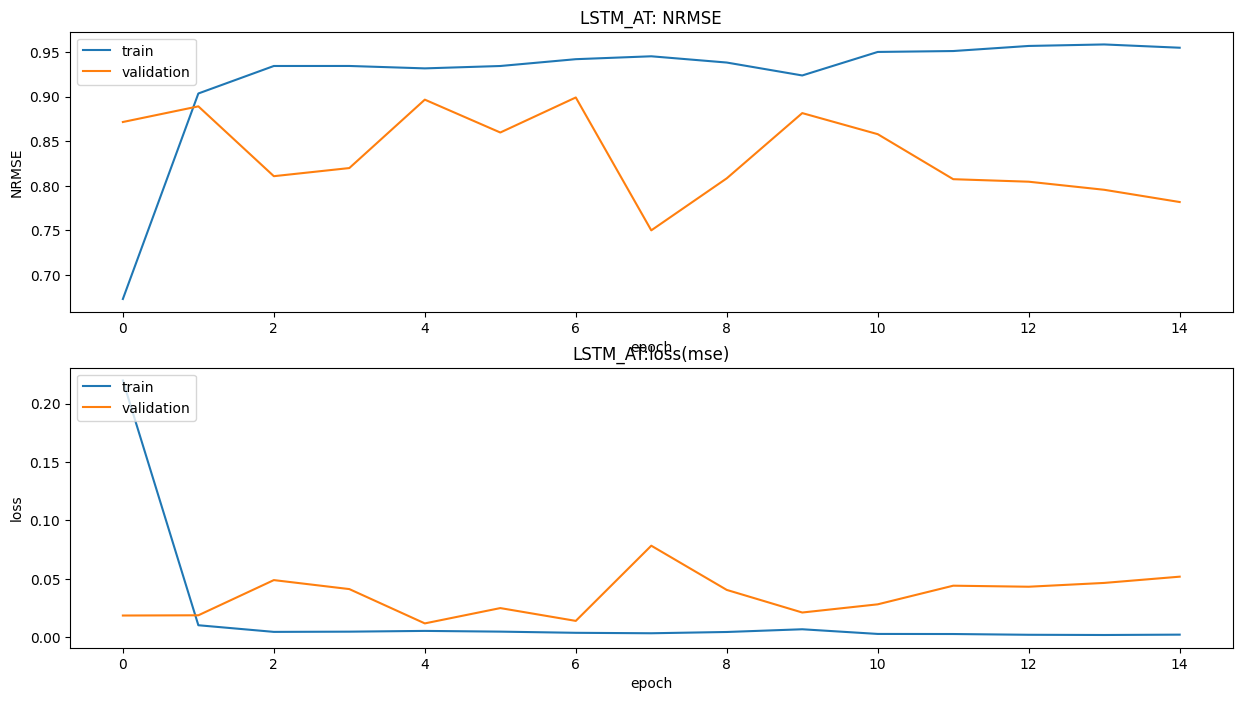

In [41]:
list_of_models=[model_MLP, model_GRU, model_CNN_LSTM, model_LSTM, model_LSTM_AT]
#list_of_models=[model_LSTM, model_LSTM_AT, model_GRU ]

for model in list_of_models:  
    optimizer = get_optimizer()
    csvLogger, model_checkpoint_callback  = checkpoints(model._name)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[NRMSE])

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(f'Initing train fo model: {model._name}')
    history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=32, shuffle=True, validation_split=0.3 ,callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback,csvLogger])

    history_metric=np.array(history.history['NRMSE']) 
    history_metric_val=np.array(history.history['val_NRMSE'])  

    plt.figure(1,figsize=(15,8))  
    # summarize history for accuracy  
    plt.subplot(211)  
    plt.plot(history_metric[history_metric>0]) 
    plt.plot(history_metric_val[history_metric_val>0])  
    plt.title(f'{model._name}: NRMSE')  
    plt.ylabel('NRMSE')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left') 
    # summarize history for loss  
    plt.subplot(212)  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])   
    plt.title(f'{model._name}:loss(mse)')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show()  
    #history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=256, shuffle=True, validation_split=0.1, callbacks=[EarlyStopping,model_checkpoint_callback, reduceLr])

### Validation

In [42]:
# carrega os modelos terinados
from tensorflow import keras
trained_best_models={}
for model in list_of_models:
    checkpoint_filepath =f'models/model_{model._name}_stock_{ticker}_lookback_{lookback}'
    trained_best_models[f'{model._name}']=keras.models.load_model(checkpoint_filepath, custom_objects={'NRMSE':NRMSE})

In [43]:
checkpoint_filepath

'models/model_LSTM_AT_stock_B3SA3_lookback_23'

In [44]:
trained_best_models

{'MLP': <keras.src.engine.functional.Functional at 0x7efff9f407c0>,
 'GRU': <keras.src.engine.functional.Functional at 0x7eff70c900a0>,
 'CNN_LSTM': <keras.src.engine.sequential.Sequential at 0x7efffad45d20>,
 'LSTM': <keras.src.engine.functional.Functional at 0x7efff9eae9b0>,
 'LSTM_AT': <keras.src.engine.functional.Functional at 0x7eff726f1900>}

In [45]:
def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  np.sum(np.square( y_true-y_pred ))
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot) )

X_real, y_real = windowing(df,features_indicators)

for idx in range(len(features_indicators)+lookback):
    X_real[:,idx]=np.squeeze(scaler.transform(X_real[:,idx].reshape(-1,1)))
#X_real=features_scaler.transform(X_real)
#y_real=scaler.transform(y_real)
#X_real=features_scaler(X_real)

#do the smae split data with the original data to compare 
X_train_real,X_test_real, y_train_real, y_test_real,T_train,_=split_data(X_real,y_real,date_time, factor=0.85)

predictions=[]
for model_name in trained_best_models:
    y_pred=scaler.inverse_transform(trained_best_models[model_name].predict(X_test))
    r2_score= R2(y_test_real, y_pred )
    print(model_name,'NN R2:', r2_score)

    predictions+=[y_pred]
predictions=np.hstack(predictions)

11/11 [==============================] - 0s 1ms/step
MLP NN R2: 0.8609578231596582
11/11 [==============================] - 0s 3ms/step
GRU NN R2: 0.7737224927244053
11/11 [==============================] - 0s 1ms/step
CNN_LSTM NN R2: 0.6554566521283314
11/11 [==============================] - 0s 4ms/step
LSTM NN R2: 0.6838454887460134
11/11 [==============================] - 0s 5ms/step
LSTM_AT NN R2: -2.3042861889428052


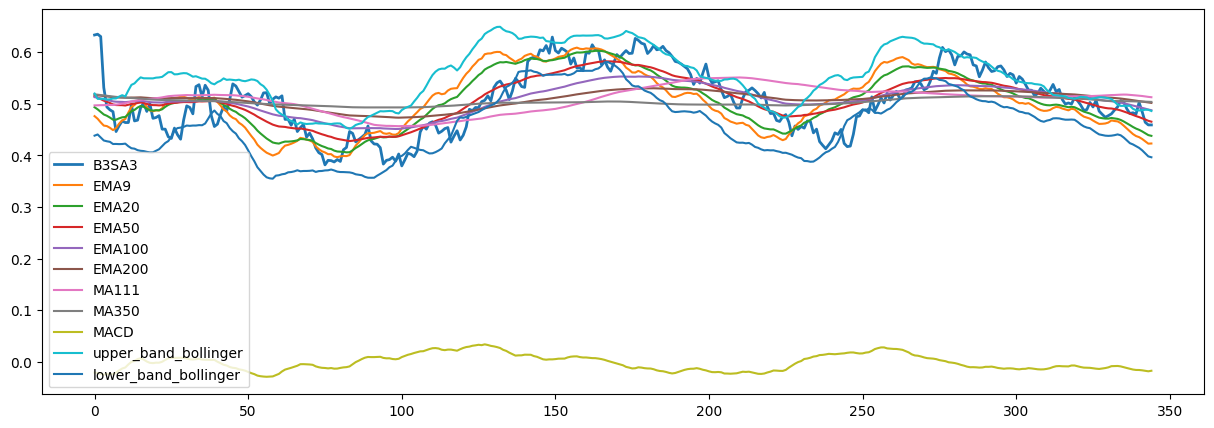

In [46]:
plt.figure(figsize=(15,5))
plt.plot(X_test[:,0],label=ticker,linewidth=2)
plt.plot(X_test[:,-len(features_indicators):])
plt.legend([ticker]+features_indicators)
plt.show()

In [47]:
y_test_real=np.hstack(y_test_real)
y_pred=np.hstack(y_pred)
y_train_real=np.hstack(y_train_real)

In [48]:
trained_best_models.keys()

dict_keys(['MLP', 'GRU', 'CNN_LSTM', 'LSTM', 'LSTM_AT'])

In [49]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

# Adiciona os valores reais ao gráfico
#fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name='Real', line=dict(color='red')))
fig.add_trace(go.Scatter(x=T_train, y=y_train_real, mode='lines',name="Dados de Treino",line=dict(color='black')))
fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name="Dados de Teste", line=dict(color='red')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'yellow', 'violet', 'yellowgreen', 'green']
for i in range(predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_test, y=predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))

# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()


### Get new values to future prediction 

In [50]:
dias_antes=1
n_steps=7

print("Temos dados até o dia :",T_test.iloc[-1].date())

print("Estamos Fornecendo dados até o dia :",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes))

print("O modelo fará previsões até o dia: ",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes) + datetime.timedelta(days=n_steps))

Temos dados até o dia : 2024-04-29
Estamos Fornecendo dados até o dia : 2024-04-28
O modelo fará previsões até o dia:  2024-05-05


In [51]:
new_predictions=[]
for model in list_of_models:
    # processo interativo para predição com o modelo de rede neural
    dias_antes=1
    n_steps=5

    if dias_antes == 0:
        NN_predictions=y_test.copy()
        # normalized data
        X_inputs=comput_features(scaler.transform(y_test_real.reshape(-1,1)),lookback, features_indicators).reshape(1,-1)
        #X_inputs=X_test.copy()
        
        T_preds=T_test.values.copy()
    else :
        NN_predictions=y_test[:-dias_antes].copy()
    
        X_inputs=comput_features(scaler.transform(y_test_real.reshape(-1,1))[:-dias_antes,:],lookback, features_indicators).reshape(1,-1)

        #X_inputs=X_test[:-dias_antes,:].copy()
        T_preds=T_test.values[:-dias_antes].copy()
    continuous_time=T_preds.copy()
    
    for k in range(n_steps):
        # normalzação das features
        #for idx in range(len(features_indicators)+lookback):
        #    X_inputs[-1,idx]=np.squeeze(scaler.transform(X_inputs[-1,idx].reshape(-1,1)))
        

        # realizar a predição interativa com o modelo
        y_pred=model.predict(X_inputs[-1,:].reshape(1,-1))

        # guarda a predição do modelo para usa-la como entrada para a proxima predição
        NN_predictions=np.append(NN_predictions,[y_pred[0][0]])
        X_inputs=np.append(X_inputs,comput_features(NN_predictions,lookback, features_indicators).reshape(1,-1),axis=0)

        
        #X_inputs=np.append(X_inputs,NN_predictions[-lookback:].reshape(1,-1),axis=0)

        # acrescenta um dia ao tempo atual 
        next_day=continuous_time[-1]+np.timedelta64(1,'D')
        continuous_time=np.append(continuous_time,next_day)    
        # verifica se o próximo dia é final de semana, se for pula até o dia útil 
        while next_day.astype('datetime64[D]').astype(datetime.datetime).isoweekday() > 5:
            # acrescenta um dia ao tempo atual 
            next_day=continuous_time[-1]+np.timedelta64(1,'D')
            continuous_time=np.append(continuous_time,next_day)

        T_preds=np.append(T_preds,next_day)
        
    new_predictions+=[scaler.inverse_transform(NN_predictions.reshape(-1,1))]
new_predictions=np.hstack(new_predictions)

1/1 [==============================] - 0s 15ms/step


In [52]:
# ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

combined_data_train=np.append(y_train,y_test[:-dias_antes])

try:
    if model_arima_fit is not None:
        print('Using ARIMA model')
except:
    model_arima = ARIMA(combined_data_train, order=(30, 2, 7))
    model_arima_fit = model_arima.fit()

    arima_predictions = model_arima_fit.predict(start=len(combined_data_train), end=len(combined_data_train)+n_steps)
    arima_predictions=np.hstack(scaler.inverse_transform(arima_predictions.reshape(-1,1)))
    arima_predictions.shape

/home/bruno.dutra/Bruno/time_series_forecast/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/bruno.dutra/Bruno/time_series_forecast/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/home/bruno.dutra/Bruno/time_series_forecast/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [53]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=T_preds[-(n_steps+1):], y=arima_predictions, mode='lines', name="Predicted ARIMA", line=dict(color='green')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'tomato', 'violet', 'yellowgreen', 'green']
for i in range(new_predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_preds, y=new_predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))


# Adiciona os valores reais ao gráfico
fig.add_trace(go.Scatter(x=T_test.values, y=y_test_real, mode='lines', name=ticker, line=dict(color='black')))
# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()

In [54]:
# modelos treinados 
[model.name for model in list_of_models]

['MLP', 'GRU', 'CNN_LSTM', 'LSTM', 'LSTM_AT']

In [55]:
model_idx=[model.name for model in list_of_models].index('CNN_LSTM')

pred_data_df=pd.DataFrame({'Data': T_preds, 'pred': new_predictions[:,model_idx]})
# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100

# Definir a variável alvo com base na variação percentual
pred_data_df['Subida'] = pred_data_df['Variacao'].apply(lambda x: 1 if x > 0.02 else 0)
pred_data_df.tail(10)

Data       pred  Variacao  Subida
339 2024-04-22  11.270000  0.798582       1
340 2024-04-23  11.090000 -1.623087       0
341 2024-04-24  10.940000 -1.371120       0
342 2024-04-25  10.830000 -1.015694       0
343 2024-04-26  11.220000  3.475939       1
344 2024-04-29  11.534228  2.724310       1
345 2024-04-30  11.498617 -0.309700       0
346 2024-05-01  11.717226  1.865703       1
347 2024-05-02  11.877862  1.352397       1
348 2024-05-03  11.981299  0.863325       1

In [56]:
pred_data_df[pred_data_df['Data']==df['Date'].iloc[-1]]

Data       pred  Variacao  Subida
344 2024-04-29  11.534228   2.72431       1

In [57]:
result=pred_data_df.iloc[-1:,:]
result

Data       pred  Variacao  Subida
348 2024-05-03  11.981299  0.863325       1

In [58]:
print("A previsão para o dia", result['Data'].item().date(),
      "é de", 'subida,' if result['Subida'].values==1 else "Descida,",
      f"de {np.round(result['Variacao'].values[0],2)}%",
      "o valor predito é de:", np.round(result['pred'].values[0],2) )

A previsão para o dia 2024-05-03 é de subida, de 0.86% o valor predito é de: 11.98


In [59]:
comput_features(y_test, lookback, features_indicators).reshape(1,-1)

array([[ 0.46500519,  0.4634688 ,  0.45220219,  0.45015366,  0.44861731,
         0.46193245,  0.46398093,  0.4706385 ,  0.48395363,  0.46193245,
         0.46295666,  0.44912944,  0.43735065,  0.42966887,  0.42505978,
         0.41993861,  0.42198708,  0.42659617,  0.41737799,  0.40969616,
         0.40406286,  0.42403556,  0.41993861,  0.42230191,  0.43601389,
         0.46336528,  0.48602282,  0.50015709,  0.51167731,  0.        ,
        -0.01643767,  0.4848999 ,  0.39400084]])

In [60]:
model_idx=[model.name for model in list_of_models].index('CNN_LSTM')
model=list_of_models[model_idx]
X_features=comput_features(y_test, lookback, features_indicators).reshape(1,-1)
scaler.inverse_transform(model.predict(X_features))

1/1 [==============================] - 0s 23ms/step


array([[11.472455]], dtype=float32)